In [1]:
import os
import json
import glob
import pandas as pd
import numpy as np
from google.colab import files

In [2]:
RUN_ENV = 'COLAB' # 'PC' or 'COLAB'

# 0 Load Data by uploading json files maded by ning (need to repeat every time b4 u start)

In [3]:
if RUN_ENV == 'COLAB':
    #json文件，地址在github库MF_KOC\Data\raw\, 导入上传文件为data frame格式
    uploaded_creator = files.upload()
    df_creator_0 = pd.read_json(next(iter(uploaded_creator)))
    df_creator = df_creator_0.copy()
    uploaded_content = files.upload()
    df_contents_0 = pd.read_json(next(iter(uploaded_content)))
    df_contents = df_contents_0.copy()
elif RUN_ENV == 'PC':
    #读取本地json文件
    df_creator = pd.read_json(r'..\Data\raw\creator_cooked.json')
    df_contents = pd.read_json(r'..\Data\raw\contents_cooked.json')

Saving creator_cooked.json to creator_cooked.json


Saving contents_cooked.json to contents_cooked.json


In [4]:
df_creator.shape

(102, 45)

In [5]:
df_contents.shape

(15941, 16)

In [6]:
df_creator.head(1).T

,0
user_id,576d3bde82ec3952ff40c5e1
nickname,达拉斯小鸡腿
avatar,https://sns-avatar-qc.xhscdn.com/avatar/61df4c...
desc,慢慢了解世界，慢慢更新自己\n吃喝玩乐+宝宝们，随心分享\n佛系更新中～比心🫰 | Zodi...
ip_location,美国
follows,837
fans,1653
interaction,11636
last_modify_ts,1741740734045
pic_per_normal_note,7.583333


In [7]:
df_contents.head(1).T

,0
note_id,67d0d605000000002903d86a
user_id,576d3bde82ec3952ff40c5e1
title,有没有和我一样【吃茶三千】一喝一个不吱声的
note_body,连地址都不想写了[笑哭R]\n虽然环境还不错，颜值也不错\n但我感觉自己完全拔草了\n尝了m...
tag_list,"达拉斯网红奶茶,达拉斯奶茶,达拉斯,达拉斯生活,达拉斯美食,达拉斯周边,达拉斯探店"
image_count,1
content_type_video,0
hot_note,0
post_time,2025-03-12 00:32:05
last_update_time,2025-03-12 00:32:06


# 2 Treat the df_contents table

In [114]:
import numpy as np
import pandas as pd
import math

# =====================
# 互动效能 Interaction Efficiency (50%)
# =====================

import numpy as np

def calculate_interaction_efficiency(df_contents, user_id):
    """
    计算互动效能得分 (50%)，使用更严格的 logistic 映射来控制高分比例。
    """

    current_content = df_contents[df_contents['user_id'] == user_id].copy()
    if current_content.empty:
        return 0.0

    # 更严格的动态基准值：使用95%分位值
    B_L = np.percentile(df_contents['liked_count'], 96)
    B_CL = np.percentile(df_contents['collected_count'], 96)
    B_C = np.percentile(df_contents['comment_count'], 96)

    # 时间衰减因子
    current_content['days_since_post'] = (current_content['scraped_time'] - current_content['post_time']).dt.days.clip(lower=0)
    current_content['decay'] = np.exp(-0.008 * current_content['days_since_post'])

    # 加权后的互动量
    like_weighted = (current_content['liked_count'] * current_content['decay']).sum()
    collect_weighted = (current_content['collected_count'] * current_content['decay']).sum()
    comment_weighted = (current_content['comment_count'] * current_content['decay']).sum()

    # 更平滑的 logistic 映射函数，scale 更低，增长更缓慢
    def logistic_map(x, base, scale=0.03):
        return 1 / (1 + np.exp(-scale * (x - base)))

    # 单项得分控制，使用映射值后再乘权重
    like_score = logistic_map(like_weighted, B_L) * 0.35
    collect_score = logistic_map(collect_weighted, B_CL) * 0.45
    comment_score = logistic_map(comment_weighted, B_C) * 0.2

    # 总得分
    total_score = (like_score + collect_score + comment_score) * 50

    # 限制最大值
    return round(min(total_score, 50), 4)




# =====================
# 互动质量 Interaction Quality (30%)
# =====================

def calculate_interaction_quality(df_creator, df_contents, user_id):
    """
    计算互动质量得分 (30%)，使用 logistic 映射函数提升分布平滑性与可区分性。
    """

    user = df_creator[df_creator['user_id'] == user_id]
    if user.empty:
        return 0.0
    user = user.iloc[0]

    fans = user['fans']
    notes = df_contents[df_contents['user_id'] == user_id]
    total_likes = notes['liked_count'].sum()
    total_collects = notes['collected_count'].sum()
    total_comments = notes['comment_count'].sum()
    total_interactions = total_likes + total_collects + total_comments

    if fans == 0 or total_interactions == 0:
        return 0.0

    # 基准值
    B_Int = 25   # 渗透率基准
    B_AF = 50    # 活跃粉丝占比
    B_CR = 10    # 评论占比

    # 计算原始指标
    penetration = total_interactions / fans * 100
    comment_ratio = total_comments / total_interactions * 100
    active_fan_ratio = 50  # 默认占比

    # logistic 映射函数（可调节 center 和 slope）
    def logistic_map(x, center, scale=0.2):
        return 1 / (1 + np.exp(-scale * (x - center)))

    if fans >= 1000:
        p_score = logistic_map(penetration, B_Int)
        a_score = logistic_map(active_fan_ratio, B_AF)
    else:
        p_score = logistic_map(penetration, B_Int)
        a_score = logistic_map(comment_ratio, B_CR)

    final_score = (p_score * 0.7 + a_score * 0.3) * 30
    return round(min(final_score, 30), 4)


# =====================
# 账号活跃度 Account Activity (20%)
# =====================

def calculate_account_activity(df_contents, user_id, now=None):
    """
    计算账号活跃度得分（20%）
    使用更宽松的 logistic 映射，提升中等活跃用户评分。
    """

    if now is None:
        now = pd.Timestamp.now()

    # 获取该用户发帖记录
    notes = df_contents[df_contents['user_id'] == user_id].sort_values('post_time')
    if notes.shape[0] < 2:
        return 0.0

    post_times = notes['post_time']
    intervals = post_times.diff().dropna().dt.days
    avg_gap = intervals.mean()
    std_gap = intervals.std()
    recent_count = notes[notes['post_time'] >= now - pd.Timedelta(days=90)].shape[0]

    # 更宽松的 logistic 函数
    def reverse_logistic(x, center, scale=2):
        return 1 / (1 + np.exp((x - center) / scale))

    # A. 发帖间隔（中心点设为 10 天，得分更宽松）
    score_gap = reverse_logistic(avg_gap, center=13, scale=3) * 7

    # B. 发帖规律性（标准差中心点设为 6）
    score_std = reverse_logistic(std_gap, center=5, scale=2) * 3

    # C. 近90天发帖频率（每篇0.8分，封顶12分）
    score_recent = min(12, recent_count * 0.7)

    # 加权提升整体得分表现（放大1.1倍后封顶）
    total_score = (score_gap + score_std + score_recent) * 1.1
    return round(min(total_score, 20), 2)

# =====================
# 汇总所有得分并加入 df_creator
# =====================

def add_final_score_to_df_creator(df_creator, df_contents):
    """
    为 df_creator 添加维度1互动类评分：
    - score1a_efficiency: 互动效能得分（最多50）
    - score1b_quality: 互动质量得分（最多30）
    - score1c_activity: 活跃度得分（最多20）
    - score1_account_influence: 综合账号影响力得分（最多100）

    不导出JSON，只更新DataFrame。
    """

    score1_eff, score1_qual, score1_act, score1_total = [], [], [], []

    for _, row in df_creator.iterrows():
        uid = row['user_id']

        # 计算各项得分
        s_eff = calculate_interaction_efficiency(df_contents, uid)
        s_qual = calculate_interaction_quality(df_creator, df_contents, uid)
        s_act = calculate_account_activity(df_contents, uid)
        s_total = s_eff + s_qual + s_act

        # 添加至列表
        score1_eff.append(s_eff)
        score1_qual.append(s_qual)
        score1_act.append(s_act)
        score1_total.append(s_total)

    # 更新 DataFrame 列
    df_creator['score1a_efficiency'] = score1_eff
    df_creator['score1b_quality'] = score1_qual
    df_creator['score1c_activity'] = score1_act
    df_creator['score1_account_influence'] = score1_total

    return df_creator



In [115]:
df_creator = add_final_score_to_df_creator(df_creator, df_contents)

df_creator.head(10).T

,0,1,2,3,4,5,6,7,8,9
user_id,576d3bde82ec3952ff40c5e1,58b325ce50c4b442ae017a30,5c0c067c0000000005022f0a,5649379603eb842b7ed00477,5d6a927e00000000010068b9,56ada7e482ec39541becb6ff,60c7988c0000000001005e11,5f03c93d000000000100466e,5801c70f6a6a697bad62b653,5a700b5de8ac2b38e1053423
nickname,达拉斯小鸡腿,小温柔Sylvia,茄茄公主 🍆,Sherry是睿睿呀,達拉斯里長,兔老板,喷嚏大魔怪,RAINA,达拉斯藤井树,间歇减肥的吃货柳🤪
avatar,https://sns-avatar-qc.xhscdn.com/avatar/61df4c...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/60c798...,https://sns-avatar-qc.xhscdn.com/avatar/62d9a1...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...,https://sns-avatar-qc.xhscdn.com/avatar/1040g2...
desc,慢慢了解世界，慢慢更新自己\n吃喝玩乐+宝宝们，随心分享\n佛系更新中～比心🫰 | Zodi...,北京🇨🇳→ 达拉斯🇺🇸\n163cm ♋巨蟹座 乐观开朗 \nIG: sylviviishe...,坐标 达拉斯 美国🇺🇸 来美14 年 家庭成员： 三只毛小孩🐶 喜欢旅游 和探索各地美食🥰 ...,北美生活探店| Chinese Girl in Dallas TX\n吃喝玩乐样样行 | 坐...,達拉斯，請多指教👋\n在朝九晚五平淡生活中，\n熱烈又燦爛的挖掘美好✨ | Zodiac: ...,我的爱消耗在许多美好的事物上\n我不断为之燃烧\n那些事物才光彩夺目 | Zodiac: 双...,一个人吃饭旅行到处走走停停（抱歉兄弟们，我只是喜欢分享适合单独出游的地点，有疑问我都会尽力回...,美妆护肤｜日常v l o g｜育儿｜探店｜旅游\n励志让每个关注我的女孩变得更漂亮更开心！\...,达拉斯小吃货一枚\n分享美好的生活~~~ | Zodiac: unknown | Age: ...,📍🇺🇸Dallas\n🧡地平线房顶工程公司\n⬆️房顶服务范围：达拉斯·奥斯汀·休斯顿\n🤪...
ip_location,美国,美国,美国,美国,美国,美国,美国,美国,美国,美国
follows,837,961,251,1173,353,928,12,2013,265,665
fans,1653,304,258,1326,794,543,710,2054,306,2454
interaction,11636,10699,3607,28064,8149,4778,6159,15093,3085,14868
last_modify_ts,1741740734045,1741746441631,1741747540369,1741807240419,1741814164296,1741822154811,1741833650475,1741908206891,1741956410430,1741962907181
pic_per_normal_note,7.583333,4.842857,5.018182,4.803279,5.5,3.066298,8.0,4.347368,3.593407,8.0


In [116]:
import json

def export_score1_nested_json(df_creator, df_contents, save_path):
    """
    生成 score1 维度的嵌套结构 JSON 文件，结构为：
    {
        "user_id": xxx,
        "score1_account_influence": xxx,
        "component_scores": {
            "score1a_efficiency": ...,
            "score1b_quality": ...,
            "score1c_activity": ...
        }
    }
    """
    nested_data = []

    for _, row in df_creator.iterrows():
        uid = row['user_id']
        score1a = calculate_interaction_efficiency(df_contents, uid)
        score1b = calculate_interaction_quality(df_creator, df_contents, uid)
        score1c = calculate_account_activity(df_contents, uid)
        score1_final = score1a + score1b + score1c

        user_data = {
            "user_id": uid,
            "score1_account_influence": round(score1_final, 4),
            "component_scores": {
                "score1a_efficiency": round(score1a, 4),
                "score1b_quality": round(score1b, 4),
                "score1c_activity": round(score1c, 4)
            }
        }

        nested_data.append(user_data)

    # 保存为 JSON 文件
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(nested_data, f, ensure_ascii=False, indent=4)

    print(f"✅ Score1 nested JSON saved to: {save_path}")


In [117]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/score1_nested.json'
export_score1_nested_json(df_creator, df_contents, save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Score1 nested JSON saved to: /content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/score1_nested.json


Descriptive Statistics for 'score1_account_influence':

count    102.000000
mean      69.573675
std       22.197782
min       27.408100
25%       50.317050
50%       75.084150
75%       87.868575
90%       95.500000
95%       96.575665
max       99.999300
Name: score1_account_influence, dtype: float64


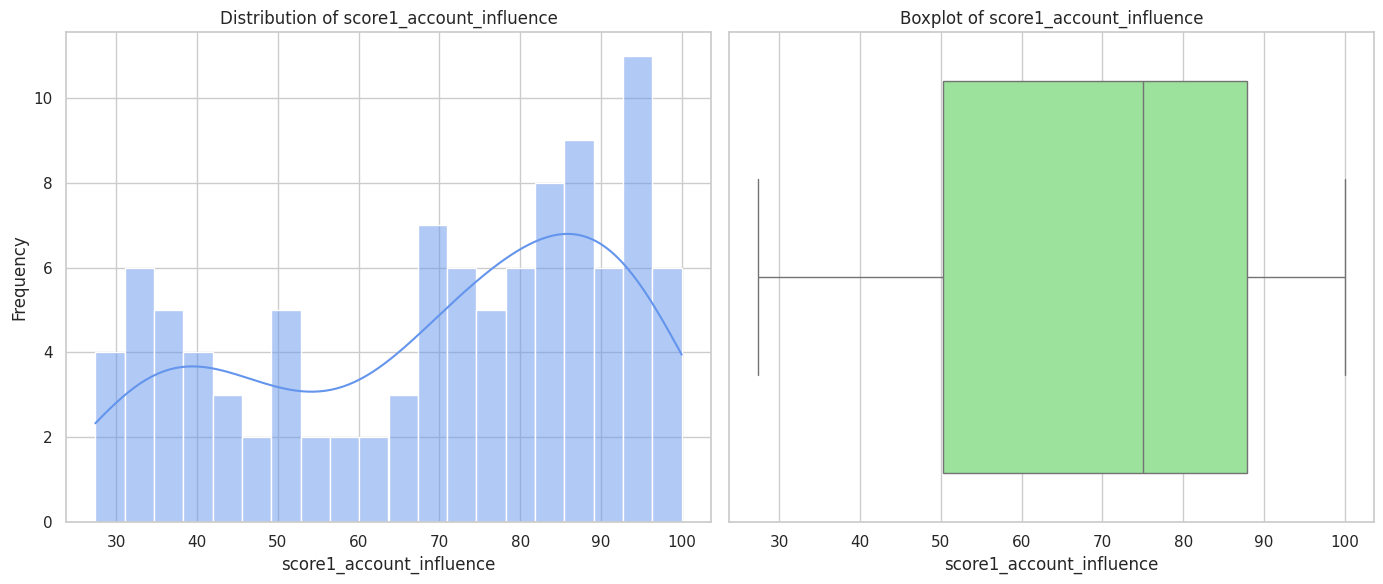

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visual style
sns.set(style='whitegrid')

# ==========================
# 1. Descriptive Statistics
# ==========================
stats = df_creator['score1_account_influence'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
print("Descriptive Statistics for 'score1_account_influence':\n")
print(stats)

# ==========================
# 2. Distribution Plots
# ==========================
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_creator['score1_account_influence'], bins=20, kde=True, color='cornflowerblue')
plt.title('Distribution of score1_account_influence')
plt.xlabel('score1_account_influence')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_creator['score1_account_influence'], color='lightgreen')
plt.title('Boxplot of score1_account_influence')
plt.xlabel('score1_account_influence')

# Display both plots
plt.tight_layout()
plt.show()


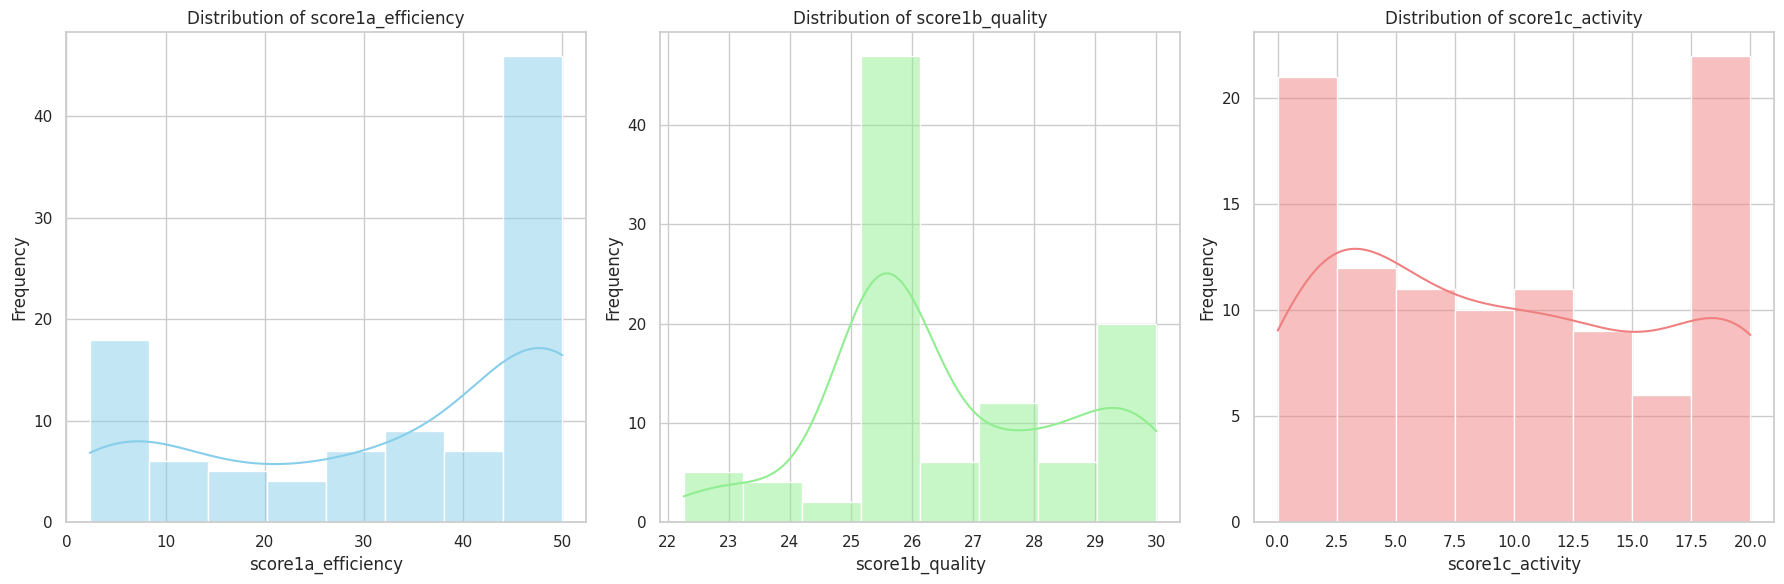

Summary Statistics for score1a_efficiency:
 count    102.000000
mean      33.170041
std       17.671567
min        2.355800
25%       18.952000
50%       39.831550
75%       49.429725
max       50.000000
Name: score1a_efficiency, dtype: float64

Summary Statistics for score1b_quality:
 count    102.000000
mean      26.601673
std        1.987560
min       22.260500
25%       25.500000
50%       25.603150
75%       28.175175
max       29.999300
Name: score1b_quality, dtype: float64

Summary Statistics for score1c_activity:
 count    102.000000
mean       9.801961
std        6.843539
min        0.010000
25%        3.395000
50%        9.415000
75%       15.945000
max       20.000000
Name: score1c_activity, dtype: float64


In [119]:
# prompt: make distribution plot for each score1 a b c    , also summery statistic feature

# Distribution Plots for score1a, score1b, and score1c

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_creator['score1a_efficiency'], kde=True, color='skyblue')
plt.title('Distribution of score1a_efficiency')
plt.xlabel('score1a_efficiency')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df_creator['score1b_quality'], kde=True, color='lightgreen')
plt.title('Distribution of score1b_quality')
plt.xlabel('score1b_quality')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df_creator['score1c_activity'], kde=True, color='lightcoral')
plt.title('Distribution of score1c_activity')
plt.xlabel('score1c_activity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Summary Statistics for score1a, score1b, and score1c
print("Summary Statistics for score1a_efficiency:\n", df_creator['score1a_efficiency'].describe())
print("\nSummary Statistics for score1b_quality:\n", df_creator['score1b_quality'].describe())
print("\nSummary Statistics for score1c_activity:\n", df_creator['score1c_activity'].describe())


In [120]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/creator_cooked_xh.json'
df_creator.to_json(save_path, orient='records', force_ascii=False,date_format='iso',indent=4 )
import os
if os.path.exists(save_path):
    print(f"文件已成功保存至：{save_path}")
else:
    print("文件保存失败，请检查路径或挂载状态")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
文件已成功保存至：/content/drive/MyDrive/DS_HighLevel_Project/KOC_Model/creator_cooked_xh.json
